In [1]:
import xupy as xp
import matplotlib.pyplot as plt
from numpy.ma import masked_array

from ekarus.e2e.utils.image_utils import reshape_on_mask, image_grid, get_circular_mask

from ekarus.e2e.single_stage_ao_class import SingleStageAO
from ekarus.analytical.kl_modes import compute_ifs_covmat
# from arte.utils.zernike_decomposer import ZernikeModalDecomposer
from arte.utils.zernike_generator import ZernikeGenerator
from arte.types.mask import CircularMask


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
def define_zernike_matrix(mask, nZern):
    """
    Create a linear combination of Zernikes on a mask.
    
    :param mask: mask defining the pupil
    :param noll_ids: tuple of Zernike noll number
    
    :return: zernike matrix [nPix,nZern]
    """
    zg = ZernikeGenerator(mask)
    nPix = xp.sum(mask.asTransmissionValue())

    noll_ids = xp.arange(nZern,dtype=int)+1
    zern_mat = xp.zeros([nPix,nZern])

    for k,noll in enumerate(noll_ids):
        zern = xp.asarray(zg.getZernike(int(noll)))
        zern_mat[:,k] = zern[~mask.mask()]

    return zern_mat

In [3]:
def define_target_roi(pupil, iwa, owa, oversampling:int, symmetric:bool=False, heightInLambdaOverD=None):
    mask_shape = max(pupil.shape)
    padded_pupil = xp.pad(1-pupil.copy(), pad_width=int((mask_shape*(oversampling-1)//2)), mode='constant', constant_values=0.0)
    X,Y = image_grid(padded_pupil.shape,recenter=True)
    rho = xp.sqrt(X**2+Y**2)
    if symmetric is True:
        where = (rho <= owa*oversampling) * (rho >= iwa*oversampling)
    else:
        where = (rho <= owa*oversampling) * (X >= iwa*oversampling) 
    if heightInLambdaOverD is not None:
        where *= (abs(Y) < heightInLambdaOverD/2*oversampling)
    return where

def calc_psf(ef, oversampling:int=8, fp_mask=None, lyot_stop=None):
    pad_width = int((max(ef.shape)*(oversampling-1)//2))
    pad_ef = xp.pad(ef, pad_width=pad_width, mode='constant', constant_values=0.0)
    ff = xp.fft.fftshift(xp.fft.fft2(pad_ef))
    if fp_mask is not None:
        ff *= fp_mask
    if lyot_stop is not None:
        pad_lyot = xp.pad(lyot_stop, pad_width=pad_width, mode='constant', constant_values=0.0)
        pf = xp.fft.ifft2(xp.fft.ifftshift(ff))
        ff = xp.fft.fftshift(xp.fft.fft2(pf * pad_lyot))
    return xp.real(ff * xp.conj(ff))

def show_psf(psf, norm=None, oversampling:int=8, title:str='', ext=0.3, vmin=-10):
    pixelSize = 1/oversampling
    imageHalfSizeInPoints= psf.shape[0]/2
    roi= [int(imageHalfSizeInPoints*(1-ext)), int(imageHalfSizeInPoints*(1+ext))]
    psfZoom = psf[roi[0]: roi[1], roi[0]:roi[1]]
    sz = psfZoom.shape
    if norm is None:
        norm = xp.max(psf)
    plt.imshow(xp.asnumpy(xp.log10(psfZoom/norm)), extent=
               [-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
               -sz[1]/2*pixelSize, sz[1]/2*pixelSize],
               origin='lower',cmap='inferno',vmin=vmin,vmax=0)
    plt.xlabel(r'$\lambda/D$')
    plt.ylabel(r'$\lambda/D$')
    cbar= plt.colorbar()
    cbar.ax.set_title('Contrast')
    plt.title(title)

In [4]:
def plot_mode_j(pupil,Mat,j:int,title:str=''):
    mode = reshape_on_mask(Mat[:,j],(1-pupil).astype(bool))
    plt.imshow(masked_array(xp.asnumpy(mode),xp.asnumpy(1-pupil)),origin='lower',cmap='RdBu')
    plt.colorbar()
    plt.axis('off')
    plt.title(title)

def display_modes(pupil, Mat, N:int=8):
    nModes = xp.shape(Mat)[1]
    plt.figure(figsize=(2.25*N,12))
    for i in range(N):
        plt.subplot(6,N,i+1)
        plot_mode_j(pupil,Mat,i,title=f'Mode {i}')
        plt.subplot(6,N,i+1+N)
        plot_mode_j(pupil,Mat,i+N,title=f'Mode {i+N}')

        plt.subplot(6,N,i+1+N*2)
        plot_mode_j(pupil,Mat,nModes//2-N+i,title=f'Mode {nModes//2-N+i}')
        plt.subplot(6,N,i+1+N*3)
        plot_mode_j(pupil,Mat,nModes//2+N+i,title=f'Mode {nModes//2+N+i}')

        plt.subplot(6,N,i+1+N*4)
        plot_mode_j(pupil,Mat,nModes-2*N+i,title=f'Mode {nModes-2*N+i}')
        plt.subplot(6,N,i+1+N*5)
        plot_mode_j(pupil,Mat,nModes-N+i,title=f'Mode {nModes-N+i}')

In [5]:
def gs_lyot(pupil, target_contrast, oversampling:int=4, phase_offset=None,
            max_its:int=20, focal_mask=None, lyot=None, beta:float=0, IF=None):

    N = max(pupil.shape)
    pad_width = N*(oversampling-1)//2

    pad_pupil = xp.pad(pupil, pad_width, mode='constant', constant_values=0.0)
    if phase_offset is None:
        phase_offset = xp.zeros_like(pad_pupil)
    else:
        phase_offset = xp.pad(phase_offset, pad_width, mode='constant', constant_values=0.0)

    if lyot is not None:
        pad_lyot = xp.pad(lyot, pad_width, mode='constant', constant_values=0.0)

    dark_zone = target_contrast < 0.1

    # a = pad_pupil.copy().astype(xp.complex64)
    a = xp.abs(pad_pupil) * xp.exp(1j*phase_offset,dtype=xp.complex64) 
    old_ff = None

    if IF is not None:
        Rec = xp.linalg.pinv(IF)
   
    for it in range(max_its):
        ff = xp.fft.fftshift(xp.fft.fft2(a))
        if focal_mask is not None:
            ff = ff * focal_mask
            pf = xp.fft.ifft2(xp.fft.ifftshift(ff))
            if lyot is not None:
                pf = pf * pad_lyot
            ff = xp.fft.fftshift(xp.fft.fft2(pf))
        
        if not xp.any(xp.abs(ff)**2 / xp.max(xp.abs(ff)**2) > target_contrast):
            break

        new_ff = ff.copy()
        if beta != 0 and old_ff is not None:
            new_ff[dark_zone] = old_ff[dark_zone] * beta - new_ff[dark_zone] * (1 + beta)
        else:
            new_ff[dark_zone] = 0
        old_ff = new_ff.copy()

        a = xp.fft.ifft2(xp.fft.ifftshift(new_ff))
        a[~pad_pupil.astype(bool)] = 0
        phase = xp.angle(a)
        if IF is not None:
            cmd = Rec @ phase[pad_pupil.astype(bool)]
            phase = reshape_on_mask(IF @ cmd,(1-pad_pupil).astype(bool))
        a = xp.abs(pad_pupil) * xp.exp(1j*(phase+phase_offset),dtype=xp.complex64) 

    psf = xp.abs(ff)**2
    ref_psf = xp.abs(xp.fft.fftshift(xp.fft.fft2(pupil)))**2
    contrast =  psf / xp.max(ref_psf)

    if it == max_its-1:
        print(f'Maximum number of iterations ({max_its:1.0f}) reached, worst contrast in dark hole is: {xp.log10(xp.max(contrast[dark_zone])):1.1f}')
    else:
        print(f'Apodizer computed in {it:1.0f} iterations: average contrast in dark hole is {xp.mean(xp.log10(contrast[dark_zone])):1.1f}, Strehl is {xp.max(psf)/xp.max(ref_psf)*1e+2:1.2f}%')
    
    pad_phase = xp.angle(a)
    phase = reshape_on_mask(pad_phase[pad_pupil.astype(bool)],(1-pupil).astype(bool))

    return phase


In [6]:
Npix = 120
cmask = CircularMask((Npix,Npix),maskRadius=Npix/2)
pupil = xp.asarray(cmask.asTransmissionValue())
# pupil = 1-get_circular_mask((Npix,Npix),mask_radius=Npix//2)
oversampling = 4

dark_zone = define_target_roi(pupil, iwa=2.6, owa=9, oversampling=oversampling)
target_contrast = xp.ones([Npix*oversampling,Npix*oversampling])
target_contrast[dark_zone] = 1e-7

phase = gs_lyot(pupil, target_contrast, oversampling=oversampling, max_its=5000, beta=0.975)
app_psf = calc_psf(pupil*xp.exp(1j*phase,dtype=xp.complex64))

Apodizer computed in 2134 iterations: average contrast in dark hole is -9.4, Strehl is 65.80%


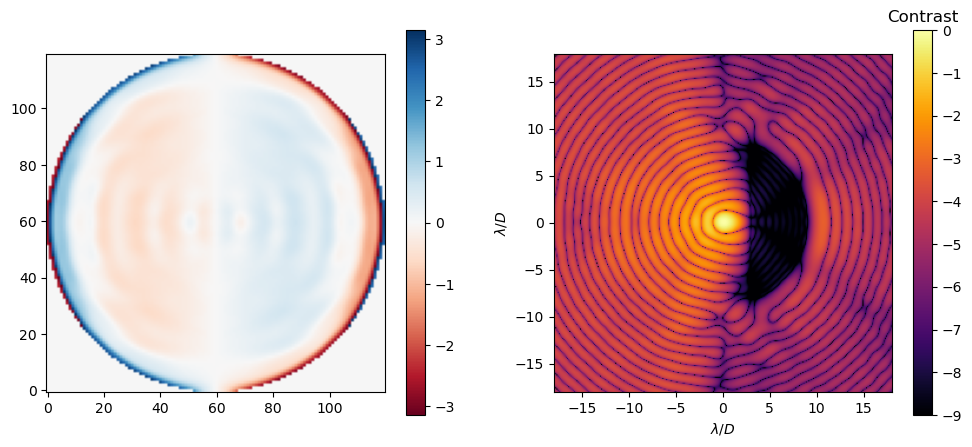

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(phase),origin='lower',cmap='RdBu')
plt.colorbar()
plt.subplot(1,2,2)
show_psf(app_psf,vmin=-9)

In [8]:
nZern = 1000
ZM = define_zernike_matrix(cmask, nZern=nZern)
ZMinv = xp.linalg.pinv(ZM)

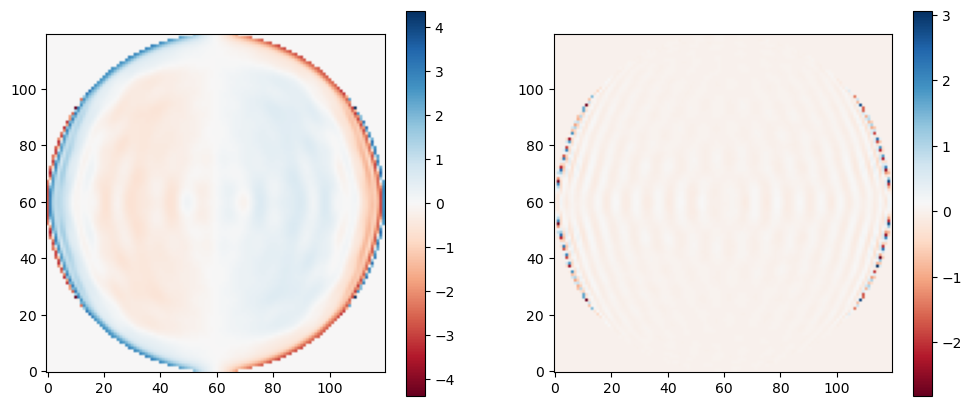

In [9]:
zern_coeffs = ZMinv @ phase[~cmask.mask()]
zern_rec = ZM @ zern_coeffs
rec_phase = reshape_on_mask(zern_rec, (1-pupil).astype(bool))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(rec_phase),origin='lower',cmap='RdBu')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(phase-rec_phase),origin='lower',cmap='RdBu')
plt.colorbar()

# zern_coeffs = xp.zeros(nZern)
# zern_coeffs[0] = 1

p = zern_coeffs/xp.sqrt(xp.sum(zern_coeffs**2))
P = xp.eye(nZern) - xp.outer(p,p)

In [10]:
Ckol = compute_ifs_covmat(pupil,diameter=8.0,influence_functions=ZM.T,r0=5e-2,L0=25,oversampling=4,verbose=True,xp=xp,dtype=xp.float32)

Computing turbulence covariance matrix...
Step 1: Computing Fourier transforms of influence functions...
Step 2: Generating phase spectrum and computing covariance matrix...
Step 3: Computing covariance matrix in Fourier domain...
Step 4: Computing covariance matrix in spatial domain...


In [11]:
Cred = P @ Ckol @ P.T

In [12]:
Cred = (Cred + Cred.T)/2

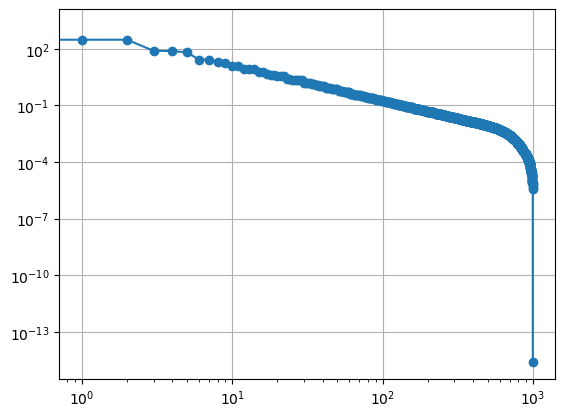

In [13]:
U,D,Vt = xp.linalg.svd(Cred)
Ml = ZM @ U #ZM @ U
Mr = (Vt @ ZM.T).T #ZM @ V

plt.figure()
plt.plot(xp.asnumpy(D),'-o')
# plt.plot(xp.asnumpy(xp.diag(Ckol)),'-o')
plt.grid()
plt.xscale('log')
plt.yscale('log')

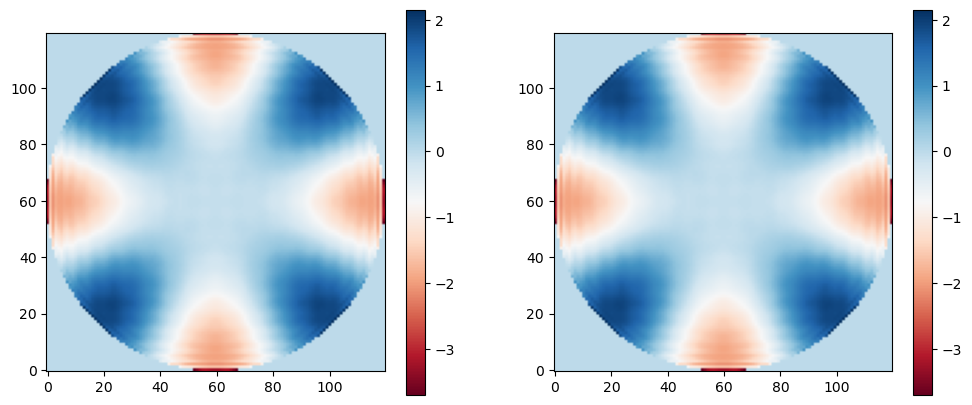

In [14]:
id = 10
mode_r = reshape_on_mask(Mr[:,id],(1-pupil).astype(bool))
mode_l = reshape_on_mask(Ml[:,id],(1-pupil).astype(bool))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(mode_r),origin='lower',cmap='RdBu')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(mode_l),origin='lower',cmap='RdBu')
plt.colorbar()

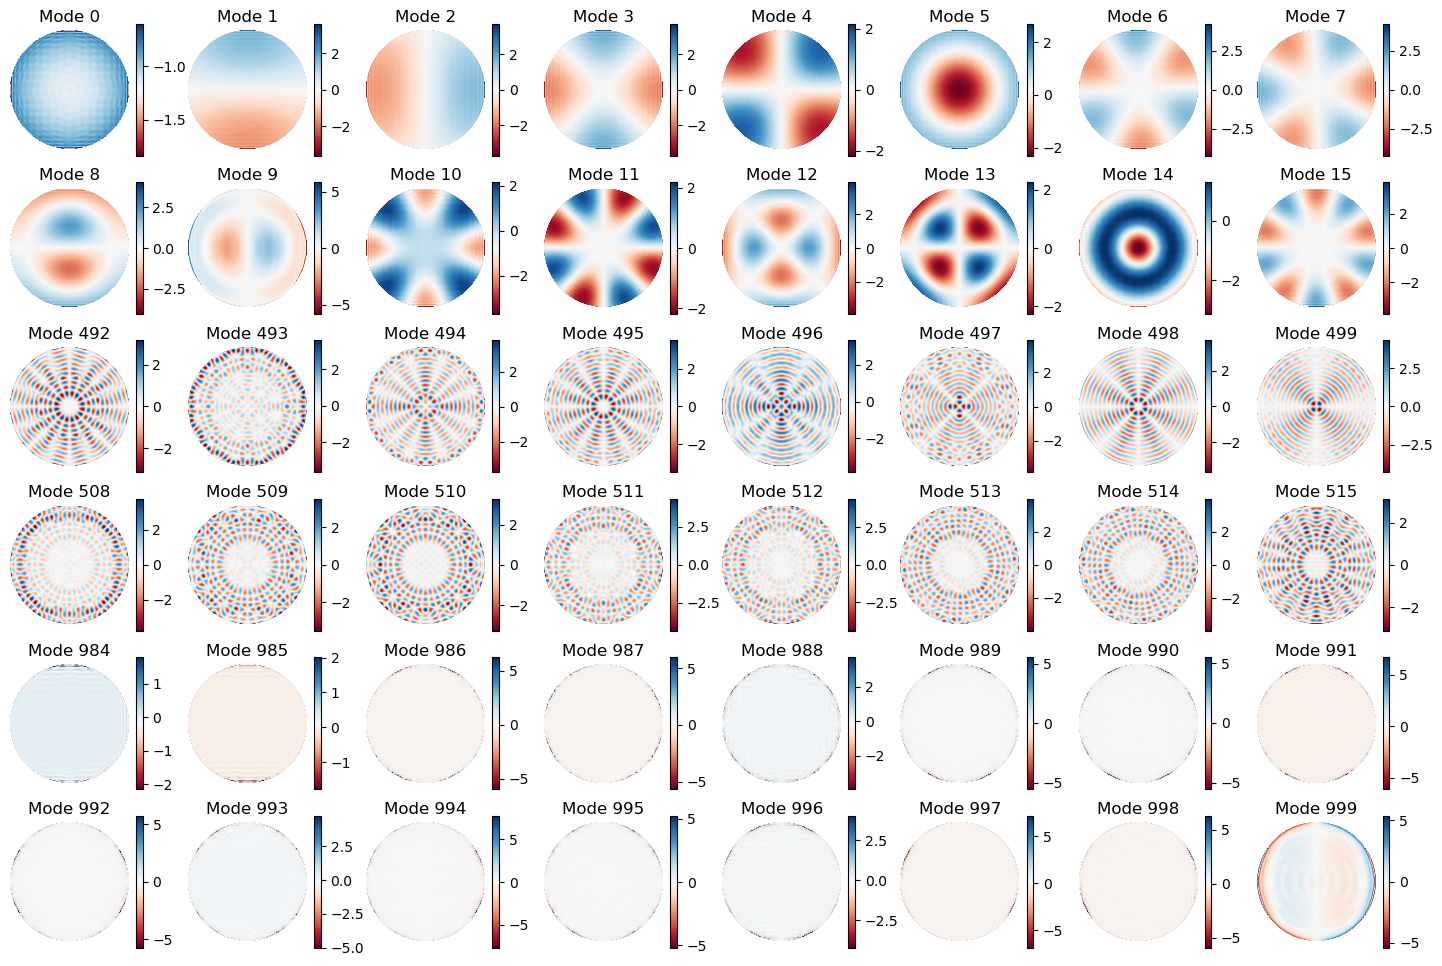

In [15]:
display_modes(pupil, Ml, N=8)

In [16]:
# cov = Ml.T @ Ml

# plt.figure()
# plt.imshow(xp.asnumpy(xp.abs(cov)))
# plt.colorbar()

# plt.figure()
# plt.plot(xp.asnumpy(xp.diag(cov)))
# plt.grid()

In [17]:
del ZM, ZMinv, Ml, Mr, U, D, Vt
# raise ValueError()

In [18]:
ssao = SingleStageAO(tn='offaxis_modalbase')

Npix = 120
pupil = 1-ssao.cmask.copy()
oversampling = 4

dark_zone = define_target_roi(pupil, iwa=2, owa=5, oversampling=oversampling)
target_contrast = xp.ones([Npix*oversampling,Npix*oversampling])
target_contrast[dark_zone] = 1e-6

apo_phase = gs_lyot(pupil, target_contrast, oversampling=oversampling, max_its=5000, beta=0.975, IF=ssao.dm.IFF)
app_psf = calc_psf(pupil*xp.exp(1j*apo_phase,dtype=xp.complex64))

Initializing devices ...
Defining the detector subaperture masks ...
Modulating 10 [lambda/D] with 68 modulation steps
Modulating 3 [lambda/D] with 20 modulation steps
Apodizer computed in 1143 iterations: average contrast in dark hole is -8.2, Strehl is 63.77%


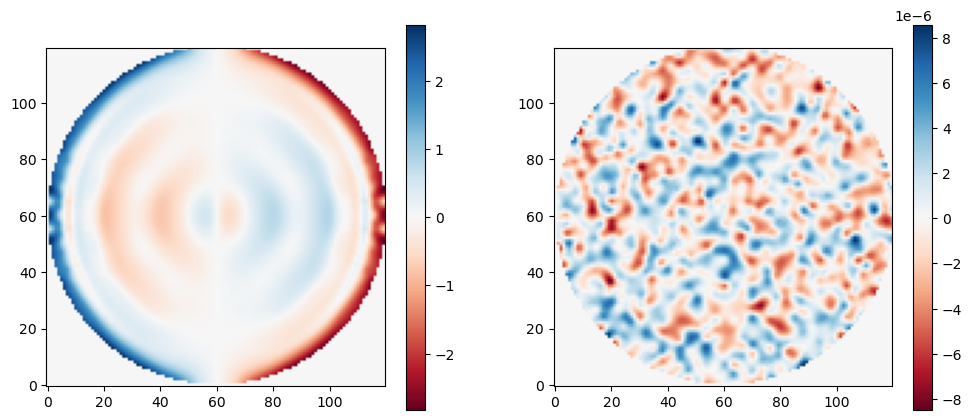

In [19]:
cmd = xp.linalg.pinv(ssao.dm.IFF) @ apo_phase[pupil.astype(bool)]
apo_rec = ssao.dm.IFF @ cmd
rec_phase = reshape_on_mask(apo_rec, (1-pupil).astype(bool))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(rec_phase),origin='lower',cmap='RdBu')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(apo_phase-rec_phase),origin='lower',cmap='RdBu')
plt.colorbar()

In [20]:
p = cmd/xp.sqrt(xp.sum(cmd**2))
P = xp.eye(ssao.dm.Nacts) - xp.outer(p,p)
Ckol = compute_ifs_covmat(pupil,diameter=8,influence_functions=ssao.dm.IFF.T,r0=10e-2,L0=25,oversampling=4,verbose=True,xp=xp,dtype=xp.float32)
Cred = P @ Ckol @ P.T

Computing turbulence covariance matrix...
Step 1: Computing Fourier transforms of influence functions...
Step 2: Generating phase spectrum and computing covariance matrix...
Step 3: Computing covariance matrix in Fourier domain...
Step 4: Computing covariance matrix in spatial domain...


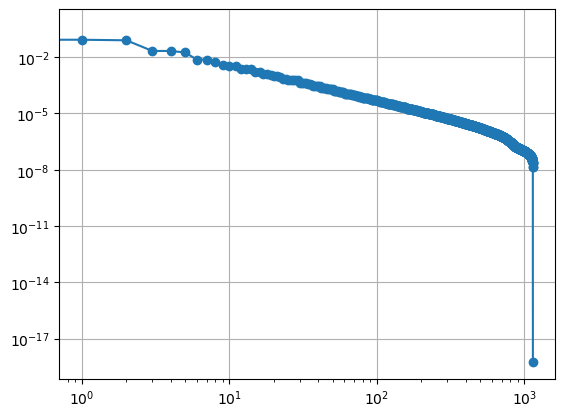

In [21]:
U,D,V = xp.linalg.svd(Cred)
Ml = ssao.dm.IFF @ U
Mr = (V @ ssao.dm.IFF.T).T

plt.figure()
plt.plot(xp.asnumpy(D),'-o')
# plt.plot(xp.asnumpy(xp.diag(Ckol)),'-o')
plt.grid()
plt.xscale('log')
plt.yscale('log')

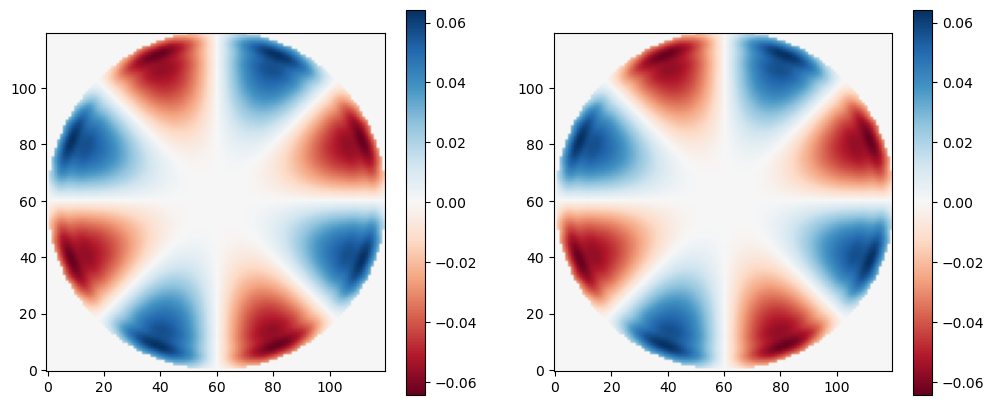

In [22]:
id = 10
mode_r = reshape_on_mask(Mr[:,id],(1-pupil).astype(bool))
mode_l = reshape_on_mask(Ml[:,id],(1-pupil).astype(bool))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(mode_r),origin='lower',cmap='RdBu')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(mode_l),origin='lower',cmap='RdBu')
plt.colorbar()

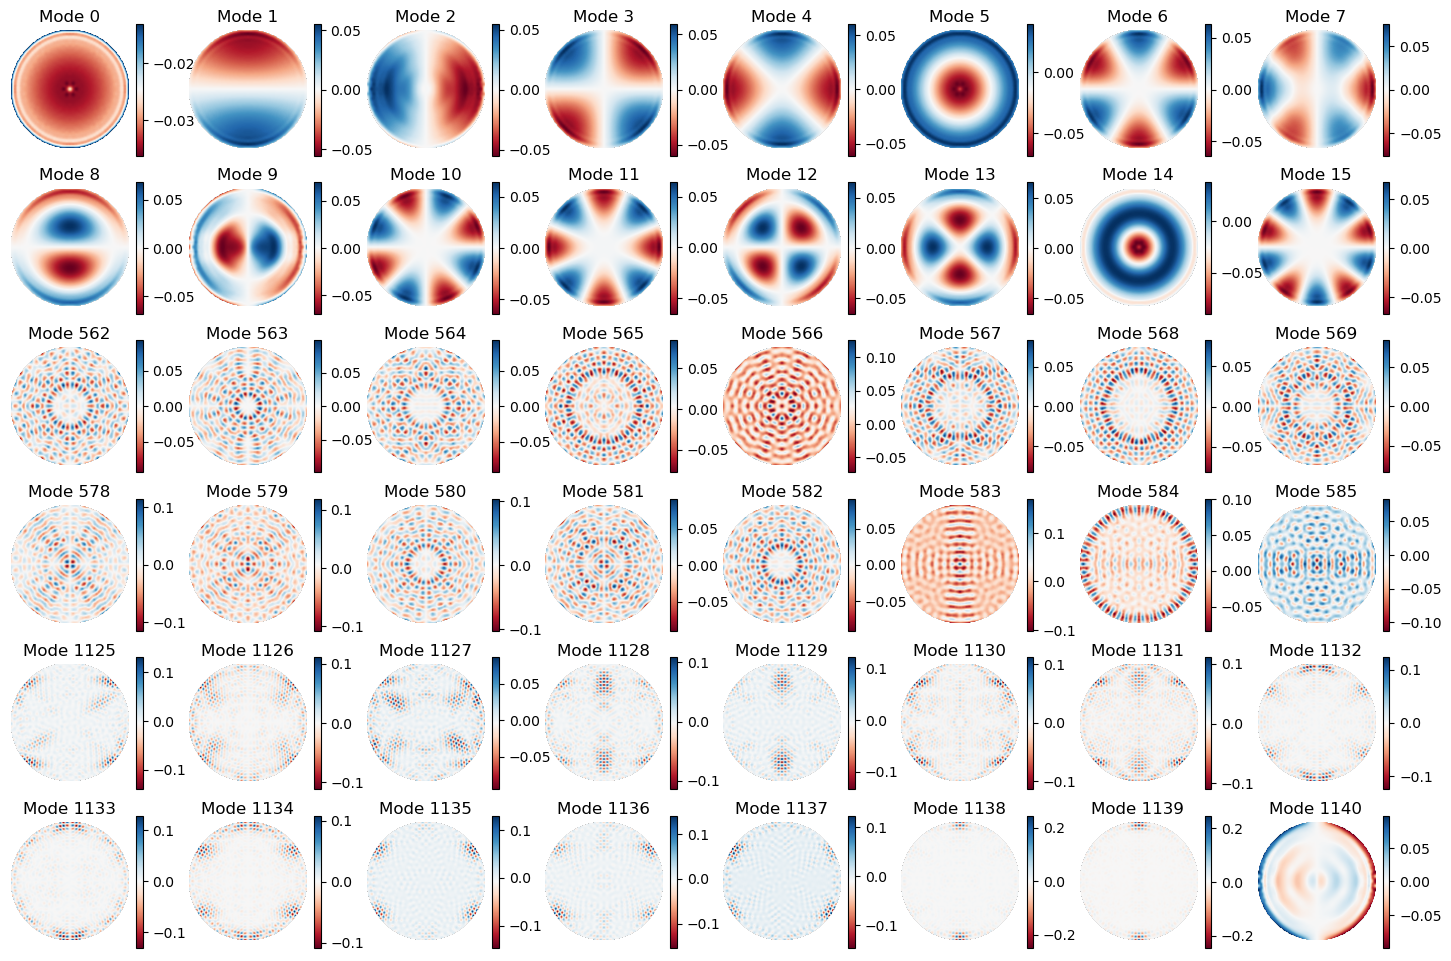

In [23]:
display_modes(pupil, Ml, N=8)

In [24]:
ssao.initialize_turbulence(tn='nine_layers_25mOS')

# # Remove piston and normalize modal-base:
# KL = xp.zeros_like(Ml.T)
# for j in range(Ml.shape[1]):
#     mode_j = Ml[:,j].T
#     mode_j -= xp.mean(mode_j)
#     mode_j /= xp.std(mode_j)
#     KL[j,:] = mode_j

# Nmodes = 1000

KL = Ml.T.copy() #Ml[:,:Nmodes].T.copy()
m2c = U.copy() #U[:,:Nmodes].copy()

# The last shall become first ...
last_mode = KL[-1,:].copy() # apodizer
first_mode = KL[0,:].copy() # 'piston'
KL[-1,:] = first_mode
KL[0,:] = last_mode

last_mode_cmd = m2c[:,-1]
first_mode_cmd = m2c[:,0]
m2c[:,0] = last_mode_cmd.copy()
m2c[:,-1] = first_mode_cmd.copy()

Fried parameter is: 13.0 [cm] (seeing = 0.78")


Text(0.5, 1.0, 'Difference')

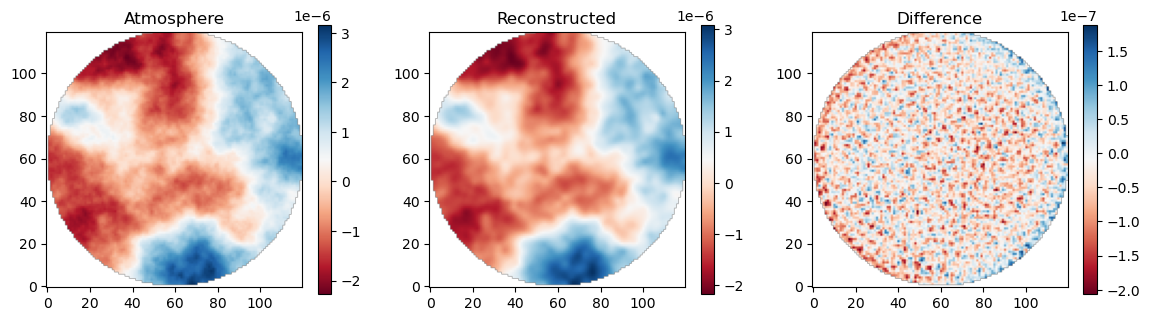

In [25]:
phase = ssao.get_phasescreen_at_time(0.0)
phi = phase[~ssao.cmask]
phi -= xp.mean(phi)

modes = xp.linalg.pinv(KL.T) @ phi
cmd = m2c @ modes
rec_phi = ssao.dm.IFF @ cmd

rec_phi_2d = reshape_on_mask(rec_phi, ssao.cmask)

plt.figure(figsize=(14,3.5))
plt.subplot(1,3,1)
plt.imshow(masked_array(xp.asnumpy(phase-xp.mean(phase[~ssao.cmask])),xp.asnumpy(ssao.cmask)),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title('Atmosphere')
plt.subplot(1,3,2)
plt.imshow(masked_array(xp.asnumpy(rec_phi_2d),xp.asnumpy(ssao.cmask)),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title('Reconstructed')
plt.subplot(1,3,3)
plt.imshow(masked_array(xp.asnumpy(phase-xp.mean(phase[~ssao.cmask])-rec_phi_2d),xp.asnumpy(ssao.cmask)),origin='lower',cmap='RdBu')
plt.colorbar()
plt.title('Difference')

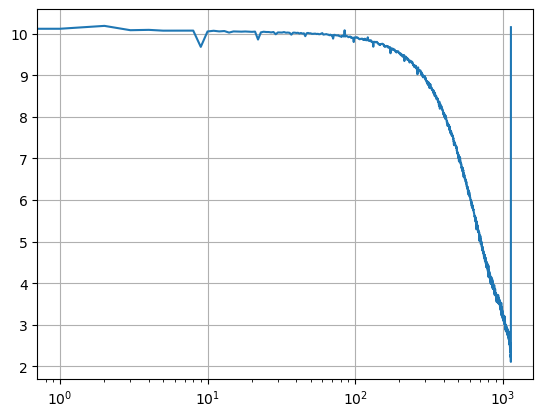

In [26]:
cov = KL @ KL.T

plt.figure()
plt.plot(xp.asnumpy(xp.diag(cov)))
plt.grid()
plt.xscale('log')

In [27]:
from astropy.io import fits
import os

if not os.path.exists(ssao.savecalibpath):
    os.mkdir(ssao.savecalibpath)
kl_path = os.path.join(ssao.savecalibpath,'KL.fits')
fits.writeto(kl_path, xp.asnumpy(KL), overwrite=True)
m2c_path = os.path.join(ssao.savecalibpath,'m2c.fits')
fits.writeto(m2c_path, xp.asnumpy(m2c), overwrite=True)

In [28]:
ssao.KL = KL
_, IM = ssao.compute_reconstructor(ssao.sc, KL, ssao.pyr.lambdaInM, ampsInM=50e-9)
ssao.sc.load_reconstructor(IM,m2c)

Calibration amplitudes: 50-7.3 [nm] (449-65 [mrad])


In [29]:
err2, in_err2 = ssao.run_loop(750e-9, starMagnitude=7.0, save_prefix='')

Saving telemetry to .fits ...


In [30]:
# Repeat but with phase offset
lambdaOverD = ssao.pyr.lambdaInM/ssao.pupilSizeInM
nPhotons = ssao.get_photons_per_second(ssao.starMagnitude)*ssao.sc.dt
apo_field = (1-ssao.cmask) * xp.exp(1j*apo_phase,dtype=xp.cfloat)

_, apoIM = ssao.compute_reconstructor(ssao.sc, KL, ssao.pyr.lambdaInM, ampsInM=50e-9, phase_offset=apo_phase[~ssao.cmask], save_prefix='apo_')
ssao.sc.load_reconstructor(apoIM,m2c)

old_sn = ssao.sc.slope_null.copy()
new_sn = ssao.sc.compute_slopes(apo_field,lambdaOverD,nPhotons)
# new_sn[0] = 10
new_sn[1:] = old_sn[1:]

Calibration amplitudes: 50-7.3 [nm] (449-65 [mrad])


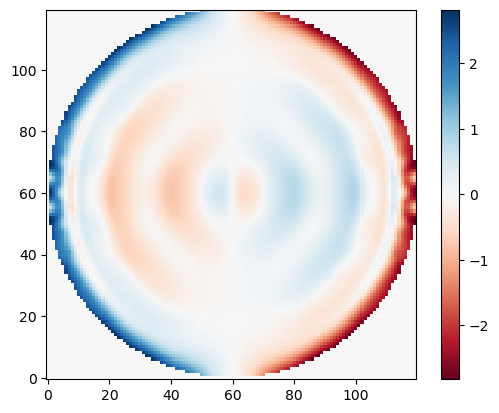

In [31]:
plt.figure()
plt.imshow(xp.asnumpy(xp.angle(apo_field)),origin='lower',cmap='RdBu')
plt.colorbar()

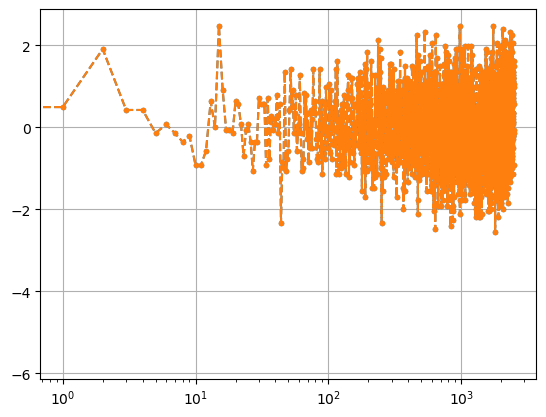

In [32]:
plt.figure()
plt.plot(xp.asnumpy(old_sn),'--.')
plt.plot(xp.asnumpy(new_sn),'--.')
plt.grid()
plt.xscale('log')

In [33]:
ssao.sc.slope_null = new_sn
apo_err2, in_err2 = ssao.run_loop(750e-9, starMagnitude=7.0, save_prefix='apo_')

Saving telemetry to .fits ...


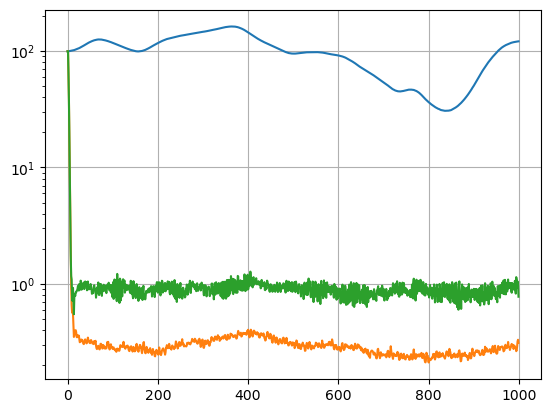

In [34]:
plt.figure()
plt.plot(xp.asnumpy(in_err2))
plt.plot(xp.asnumpy(err2))
plt.plot(xp.asnumpy(apo_err2))
plt.yscale('log')
plt.grid()

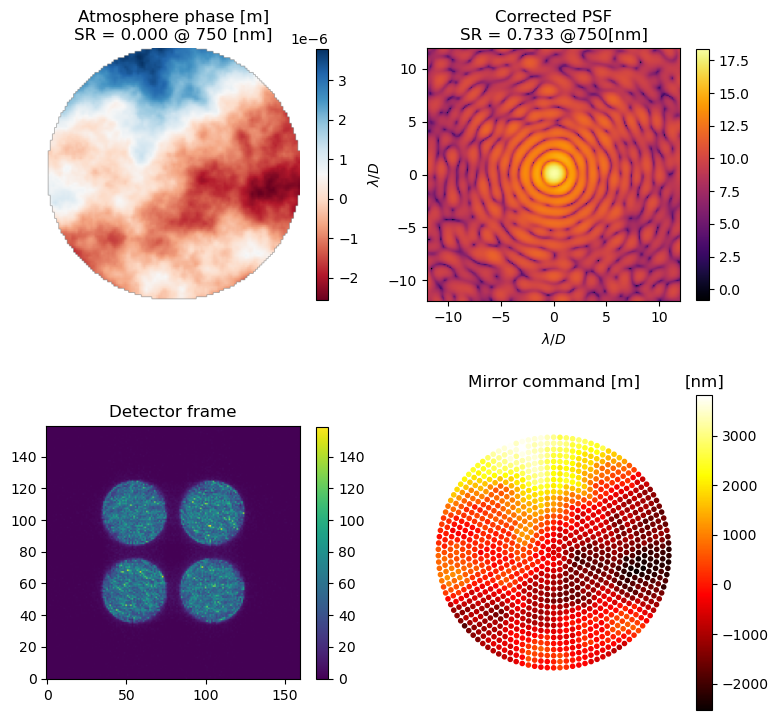

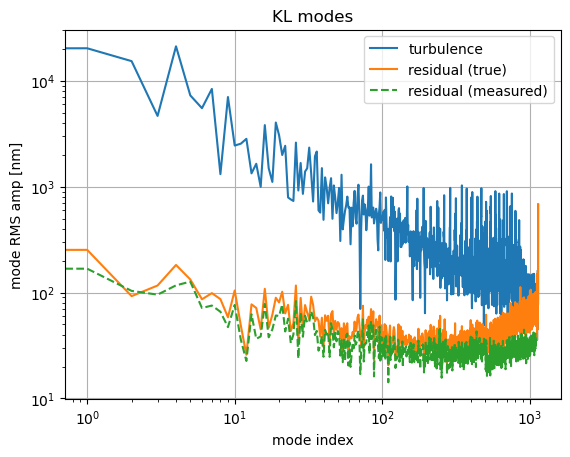

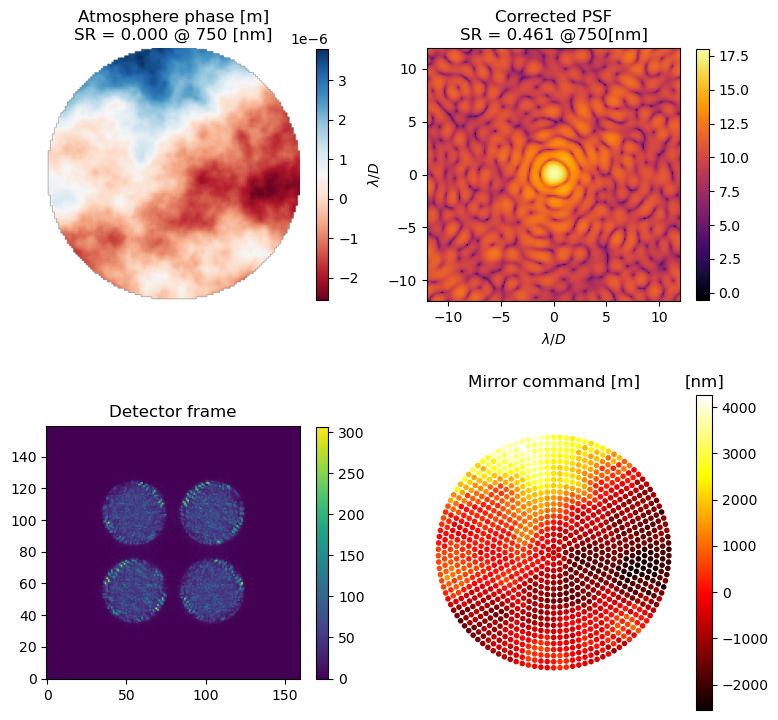

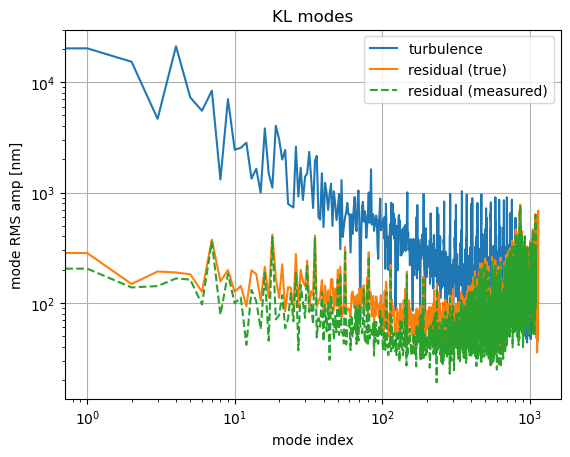

In [35]:
ssao.plot_iteration(lambdaRef=750e-9, save_prefix='')
ssao.plot_iteration(lambdaRef=750e-9, save_prefix='apo_')